## Fine Tuning BERT for Sentiment Analysis

In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.2 MB/s eta 0:00:00


In [4]:
# package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import BertModel, BertTokenizer
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import os
import random

# Loading testing data

In [ ]:
# 文本清理函數
def text_clean(content):
  cleaned_content = content
  cleaned_content = re.sub(r'[\n\r]', '', cleaned_content) # 換行符號
  cleaned_content = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', cleaned_content) # 移除url
  cleaned_content = re.sub(r'<.*?>', '', cleaned_content) # 移除html標籤
  cleaned_content = re.sub(r'\d+', '', cleaned_content) # 數字
  cleaned_content = re.sub(r'[^\w\s]', '', cleaned_content) # 移除標點符號
  cleaned_content = re.sub(r"\s+", "", cleaned_content) # 清除空格
  return cleaned_content
# 準備測試資料
selected_columns = ['content', 'sentiment']
folder_path = './testing_data'
bert_test_data = pd.DataFrame()
for filename in os.listdir(folder_path):
    df_temp = pd.read_csv(f'{folder_path}/{filename}')
    bert_test_data = pd.concat([bert_test_data, df_temp[selected_columns]], ignore_index=True)
# Drop duplicate rows
bert_test_data.drop_duplicates(inplace=True)
bert_test_data = bert_test_data.dropna(axis=0, how='any', subset=['content'])
bert_test_data["sentiment"] = bert_test_data["sentiment"].replace({'0': 0, '1': 1, '2': 2})
# Assuming your DataFrame is called 'df' and the column you want to check is 'column_name'
invalid_values = [0, 1, 2]
# Drop the rows where the values in 'column_name' are in the invalid_values list
bert_test_data = bert_test_data[bert_test_data['sentiment'].isin(invalid_values)]
# Apply text clean function
bert_test_data['cleaned_content'] = bert_test_data['content'].apply(text_clean)

In [ ]:
# 載入我們的模型
bert_model = BertModel.from_pretrained("./model_file")
tokenizer = BertTokenizer.from_pretrained("./model_file")

In [ ]:
test_data = bert_test_data


In [ ]:
class ContentDataset(Dataset):

  def __init__(self, contents, targets, tokenizer, max_len):
    self.contents = contents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.contents)
  
  def __getitem__(self, item):
    content = str(self.contents[item])
    target = int(self.targets[item])

    encoding = self.tokenizer.encode_plus(
      content,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'content_text': content,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ContentDataset(
    contents=df['content'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32
MAX_LENGTH = 350
test_data_loader = create_data_loader(bert_test_data, tokenizer, MAX_LENGTH, BATCH_SIZE)

# Classifier

In [ ]:
# # transformer
# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained("./model_file")
#         self.drop = nn.Dropout(p=0.5)
#         self.transformer = nn.TransformerEncoderLayer(self.bert.config.hidden_size, nhead=8)
#         self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.relu = nn.ReLU()

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         pooled_output = outputs[1]
#         output = self.drop(pooled_output)
#         output = self.transformer(output.unsqueeze(0))  # Add Transformer layer
#         output = output.squeeze(0)
#         output = self.fc(output)
#         return output
# # two fully connected layers 256 + 128
# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained("./model_file")
#         self.drop = nn.Dropout(p=0.5)  # Increased dropout to 0.5
#         self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
#         self.fc2 = nn.Linear(256, 128)  # Additional fully connected layer
#         self.fc3 = nn.Linear(128, n_classes)  # Additional fully connected layer
#         self.relu = nn.ReLU()

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         pooled_output = outputs[1]
#         output = self.drop(pooled_output)
#         output = self.fc1(output)
#         output = self.relu(output)
#         output = self.drop(output)
#         output = self.fc2(output)
#         output = self.relu(output)
#         output = self.drop(output)
#         output = self.fc3(output)
#         return output
# # one fully connected layer 256
# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained("./model_file")
#         self.drop = nn.Dropout(p=0.3)
#         self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)  # Additional fully connected layer
#         self.fc2 = nn.Linear(256, n_classes)  # Additional fully connected layer
#         self.relu = nn.ReLU()  # Activation function

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         pooled_output = outputs[1]
#         output = self.drop(pooled_output)
#         output = self.fc1(output)
#         output = self.relu(output)
#         output = self.drop(output)
#         output = self.fc2(output)
#         return output
# original
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("./model_file")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = outputs[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Apply the model

In [ ]:
class_names = ['N', 'M', 'P']
model = SentimentClassifier(len(class_names))
# Load the state dict into the model
state_dict_path = "best_model_state_20+10.bin"
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

# Testing

In [ ]:
# using gpu
def get_predictions(model, data_loader):
  model = model.eval()
  
  content_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["content_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      # print(preds)
      

      probs = F.softmax(outputs, dim=1)

      content_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return content_texts, predictions, prediction_probs, real_values

In [ ]:
y_content_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           N       0.90      0.77      0.83     17550
           M       0.69      0.84      0.76     19466
           P       0.88      0.80      0.84     19755

    accuracy                           0.81     56771
   macro avg       0.82      0.81      0.81     56771
weighted avg       0.82      0.81      0.81     56771



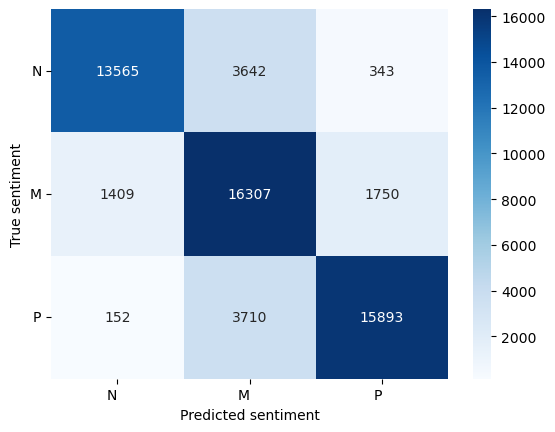

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Accuracy above 350 words:  0.713335245196444
Accuracy below 350 words:  0.8472645922310352


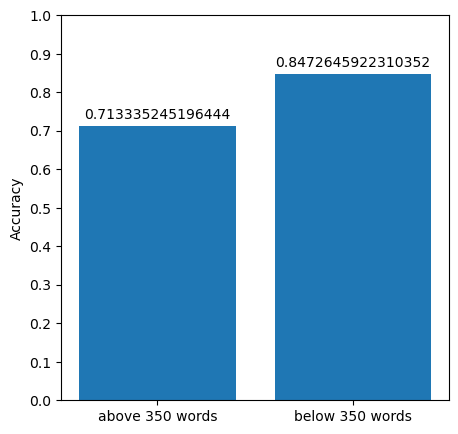

In [ ]:
correct_above = 0
false_above = 0
correct_below = 0
false_below = 0
for i in range(len(y_test)):
  if len(y_content_texts[i]) > 350:
    if y_test[i] == y_pred[i]:
      correct_above += 1
    else:
      false_above += 1
  else:
    if y_test[i] == y_pred[i]:
      correct_below += 1
    else:
      false_below += 1
#calculate the accuracy
print("Accuracy above 350 words: ", correct_above/(correct_above+false_above))
print("Accuracy below 350 words: ", correct_below/(correct_below+false_below))
# plot the bar chart of the accuracy, and add the number of accuracy on the top of each bar
plt.figure(figsize=(5, 5))
plt.bar(['above 350 words', 'below 350 words'], [correct_above/(correct_above+false_above), correct_below/(correct_below+false_below)])
plt.text(0, correct_above/(correct_above+false_above)+0.01, str(correct_above/(correct_above+false_above)), ha='center', va='bottom')
plt.text(1, correct_below/(correct_below+false_below)+0.01, str(correct_below/(correct_below+false_below)), ha='center', va='bottom')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


## 單獨看一筆testing資料的結果

我想了解銷售人員的專業能力跟產品有關嗎？賣賓士車就是超級業務員嗎？賣手飾跟鞋子衣服月餅的店員就不能算超級銷售員嗎？
我覺得只是商品的不同，那如果賣賓士車一個月要賣幾台才是超級業務員？

True sentiment: M


(0.0, 1.0)

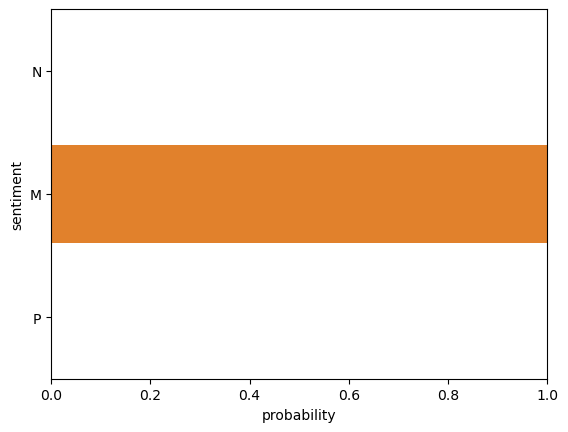

In [ ]:
idx = random.randint(0, len(y_test)-1)

content_text = y_content_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
from textwrap import wrap
print("\n".join(wrap(content_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

# Demo

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


tensor([[4.7158e-06, 4.9801e-05, 9.9995e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


(0.0, 1.0)

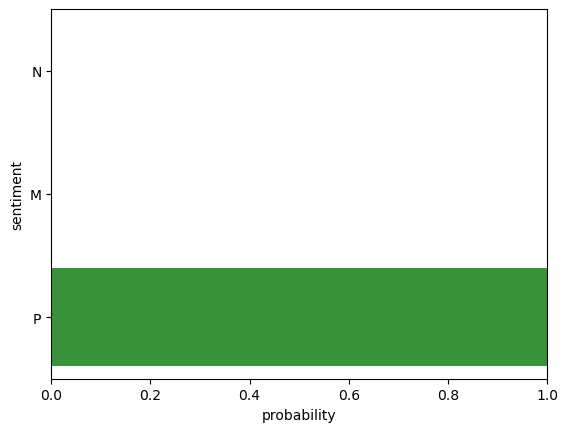

In [ ]:
# sample  = "郭台銘決定參選角逐2024總統大位" # M
# sample = "這堂課強調使用Python進行資料分析和機器學習。Python是一個廣泛使用且強大的程式語言，擁有豐富的資料處理和機器學習函式庫，如NumPy、Pandas和Scikit-learn。透過學習Python，學生能夠輕鬆地處理和分析大量的資料，並建立機器學習模型。此外，本課程內容涵蓋了資料分析和機器學習的關鍵主題，學生將學習資料清理和預處理的技巧，如資料讀取、缺失值處理和特徵選擇。我們也將學習建立和評估不同類型的機器學習模型，包括監督式學習和非監督式學習方法。這些主題的深入探討將使學生能夠在真實世界的問題中應用機器學習技術。更重要的是，這堂課強調實作導向，學生將有機會進行實際的資料分析和機器學習專案，從資料探索到模型建立和評估。這種實作導向的學習方式能夠幫助學生將所學的理論知識應用到實際場景中，提升他們的問題解決能力和實踐能力。最後，這堂課的教學團隊非常優秀和專業，他們具有豐富的資料分析和機器學習經驗，能夠清晰地傳達核心概念和技術。他們還提供了豐富的學習資源和支援，讓學生能夠深入理解和掌握課程內容。" # P
# sample = "今天去算紫葳斗數，他說我跟心儀的對象沒有機會" # N
#古文共賞
# sample = "少小離家老大回，鄉音無改鬢毛催，兒童相見不相識，笑問「客從何處來」" ＃ N
# sample = "去年今日此門中，人面桃花相映紅。人面不知何處去，桃花依舊笑春風。" # N -> M

#寫給心儀對象的聖誕卡
# sample =  "雖然我們認識的時間不長，但跟你聊天的感覺都很自在，也可從字裡行間中看出你是個善良可愛的女生。要約妳出去真的很緊張，但很慶幸能過跟你一起過聖誕節，原本想說送個耶誕小禮物，但怕讓你覺得有壓力，所以就決定寫了一張祝福小卡。希望這張小卡可以給你帶來小小的動力！期末考加油唷～"# P
#給教授的參訪信
sample =  "我是魏X翰，目前就讀於台灣大學生物機電工程學系四年級，今年有幸能夠推甄上生醫電資研究所電子組。在大學期間，以大專生的身分待在陳X瑜教授所帶領的機器學習與生物資訊實驗室，學習生醫相關的知識與參與部分研究計畫。目前有在進行大專生計畫中，主題是將新穎影像辨識方法應用於無標註之急性骨髓白血病全切片影像的學習，主要是在做WSI影像的處理以及影像辨識，並試著透過影像來得到更多訊息幫助醫療發展。在看過教授的M2Lab網站後，發現教授的研究方向也是與基因定序與機器學習的應用相關，與目前所待的c4Lab研究方向十分相近。但因為網站上除了教授您的研究成果外，沒有太多關於實驗室的其他資訊。故希望透過郵件的方式向教授您請教貴實驗室的發展以及未來的研究方向。還有對於未來的研究生有什麼期待，或希望我們能夠具備什麼技能。附件為我的簡單自我簡歷，其中包含大學時期的修課列表，以及比較熟悉的專業能力，還有大學四年的學習經歷。"# P
# sample = "" # 請自行輸入

encoded_sample = tokenizer.encode_plus(
  sample,
  max_length=MAX_LENGTH,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
sample_input_ids = encoded_sample['input_ids'].to(device)
sample_attention_mask = encoded_sample['attention_mask'].to(device)

output = model(sample_input_ids, sample_attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
print(probs)
pred_ = pd.DataFrame({
  'class_names': class_names,
  'values': probs.cpu().detach().numpy().flatten()
})
sns.barplot(x='values', y='class_names', data=pred_, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])